# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
from numpy import linalg as la
# from scipy.optimize import curve_fit
from scipy import ndimage

%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD3L1D_STK(xAxis, tAxis, sigma_dict, tPara_ict, spaceDivideStep = 1, timeDivideStep = 60):
# divideStep upsample rate
# tPara_dict must include these temporal parameters: alpha, beta, gamma, g, h, l 
    dx = np.mean(np.diff(xAxis)) / spaceDivideStep
    xAxis = AxisByHalfLen(xAxis[-1], dx)
    gaussK = {} # Gassian Kernel
    for (key,value) in sigma_dict.items():
        halfKLen = min( value*8, xAxis[-1])
        kAxis = AxisByHalfLen(halfKLen, dx)
        gaussK[key] = Gaussian_filter_1d(kAxis,value)

    dt = np.mean(np.diff(tAxis)) / timeDivideStep
    tAxis = np.arange(0, tAxis[-1]+dt, dt)
    stimulus = np.zeros([len(tAxis), len(xAxis)])
    if "tau_delay" in tPara_ict:
        delayed_delta = tAxis /tPara_dict['tau_delay']/tPara_dict['tau_delay'] *np.exp(-tAxis/tPara_dict['tau_delay']) *dt
        stimulus[:,int(len(xAxis)/2)] = delayed_delta
    else:
        stimulus[0,int(len(xAxis)/2)] = 1

    for key in ['alpha','beta','gamma','m','n','g','h','l']: # initialize tPara_ict
        if not key in tPara_ict.keys(): 
            tPara_ict[key] = 1

    z = np.zeros_like(stimulus)
    y = np.zeros_like(stimulus)
    w = np.zeros_like(stimulus)

    for i in np.arange(len(tAxis)-1):
        R = {'s2y':stimulus[i,:], 'y2z':y[i,:], 'y2w':y[i,:], 'z2y':z[i,:], 'z2w':z[i,:]} # initialization
        for key in R.keys():
            if key in gaussK:    R[key] = np.convolve(R[key],gaussK[key],'same')*dx

        dy = (-tPara_dict['alpha']*y[i,:] + tPara_dict['m']*R['s2y'] - tPara_dict['n']*R['z2y'])*dt
        dz = (-tPara_dict['beta'] *z[i,:] + tPara_dict['g']*R['y2z']                           )*dt
        dw = (-tPara_dict['gamma']*w[i,:] + tPara_dict['h']*R['y2w'] - tPara_dict['l']*R['z2w'])*dt

        y[i+1,:] = (y[i,:]+dy)
        z[i+1,:] = (z[i,:]+dz)
        w[i+1,:] = (w[i,:]+dw)
    actual_xAxisIndex = np.append( np.arange(int(len(xAxis)/2), -1, -spaceDivideStep)[:0:-1], np.arange(int(len(xAxis)/2), len(xAxis), spaceDivideStep) )
    y = y[::timeDivideStep, actual_xAxisIndex]/dx/dt #
    z = z[::timeDivideStep, actual_xAxisIndex]/dx/dt
    w = w[::timeDivideStep, actual_xAxisIndex]/dx/dt

    return w, z, y

def AxisByHalfLen(halfLen, dx):
    axis = np.arange(0, halfLen+dx, dx)
    return np.append(-1*axis[:0:-1], axis)


# Set Parameter

## Exp

In [4]:
# temporal
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

tPara_dict = {
'alpha':1.302408,
'beta':13.024075,
'gamma':34.901452,
'g':460.016331,
'l':0.021331,
'tau_delay':0.028650,
'm':127.832600} # m can be nagative for off cell

# spatial
sigma_dict = dict()
sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 
sigma_dict['y2z'] = 0.05*sigma_dict['y2w']   # has to be small enough

dx = 0.005 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) # Half length of xais, (mm)
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

## By hand

In [5]:
# # temporal
# dt = 0.01 #large dt will cause  overflow
# Tstep = int(1./dt)
# TKtaxis = np.arange(Tstep)*dt

# tPara_dict = {
# 'alpha':40,
# 'beta':2,
# 'gamma':100,
# 'm':40,
# 'n':200,
# 'g':2,
# 'h':50,
# 'l':50,
# 'tau_delay':0.02} # m can be nagative for off cell

# # spatial
# sigma_dict = dict()
# sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
# # sigma_dict['y2z'] =10/9*sigma_dict['y2w'] 
# sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 

# dx = 0.005 # OLED pixel2micro = 7.6
# hXstep =  int(2 /dx) # Half length of xais, (mm)
# # hXstep =  int(1.015 /dx) # range of Checkboard, 1.5*sqrt(2)/2
# SKxaxis = np.arange(-hXstep,hXstep+1)*dx

# STK

In [6]:
Delta_output_w, zts, Delta_output_y = NGD3L1D_STK(SKxaxis, TKtaxis, sigma_dict, tPara_dict)

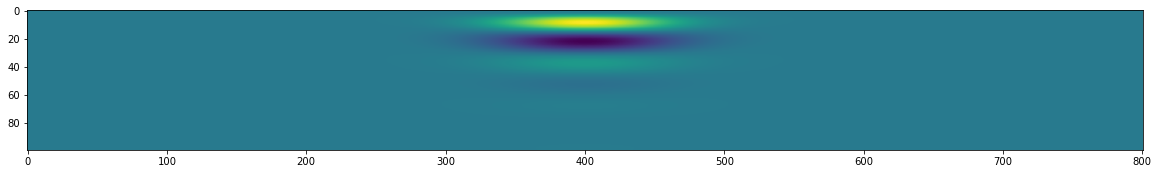

In [7]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)


In [8]:
delSTK = Delta_output_w

In [9]:
iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
mag_Se2del = 1/np.max(SeSTK)*np.max(delSTK)
SeSTK = SeSTK*mag_Se2del

# SVD

In [10]:
U,sigma,VT=la.svd(delSTK)

In [11]:
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
        

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[9.61498634e-01 3.84461338e-02 5.38562577e-05 1.36575741e-06
 9.63243521e-09]


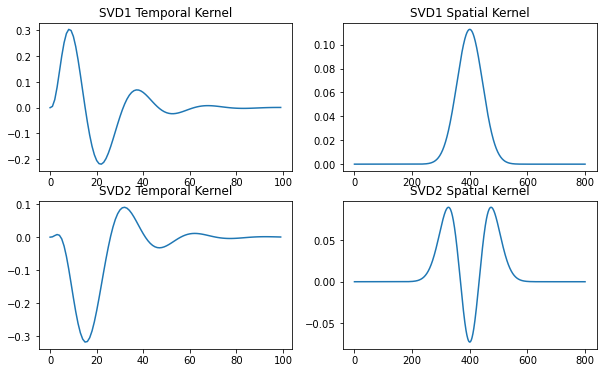

In [12]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(10, 6)

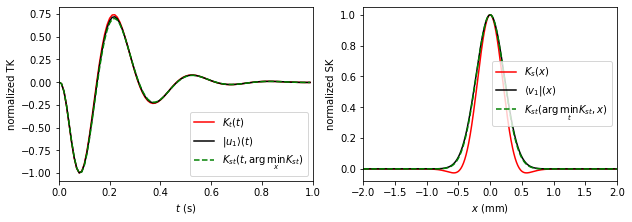

In [13]:
fig, ax = plt.subplots(1,2)
ax[1].plot(SKxaxis, iSK/np.max(iSK), 'r',label=r'$K_s(x)$')
ax[1].plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), 'k',label=r'$\left\langle {v_1} \right|(x)$')
ax[1].plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), 'g--',label=r'$K_{st}(\arg\min_{t} K_{st}, x)$')
ax[1].legend(loc='best')
ax[1].set_ylabel('normalized SK')
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_xlim([-2,2])

ax[0].plot(TKtaxis, -iTK/np.max(iTK), 'r',label=r'$K_t(t)$')
ax[0].plot(TKtaxis, -U[:,0]/np.max(U[:,0]), 'k', label=r'$\left| u_1 \right\rangle(t)$')
ax[0].plot(TKtaxis, -delSTK[:, np.where(delSTK == np.max(delSTK))[1][0]]/np.max(delSTK), 'g--',label=r'$K_{st}(t, \arg\min_{x} K_{st})$')
ax[0].set_xlabel(r'$t$ (s)')
ax[0].set_ylabel('normalized TK')
ax[0].set_xlim([0,1])
# ax[0].plot(TKtaxis, U[:,1]/np.max(U[:,1]) *sigma[1]/sigma[0], label='u2')

ax[0].legend(loc='best')
fig.set_size_inches(10,3.2)

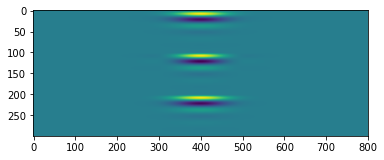

In [14]:
plt.imshow(np.vstack((delSTK,SeSTK,SVDSTK)))

In [15]:
STK = {}
STK['Ori'] = delSTK
STK['SbI'] = SeSTK # separated by integration
STK['SVD'] = SVDSTK

# SMB

In [16]:
def STconvolve(x, k:list, dx, dt):
    if len(k) == 1: # A spatial temporal kernel
        k = k[0]
        output = np.zeros([x.shape[0],max(k.shape[1], x.shape[1])])
        for i in range(x.shape[0]):
            for ii in np.arange(max(i-k.shape[0]+1, 0), i+1):
                output[i,:] += np.convolve(x[ii,:],k[i-ii, :],'same')*dx*dt
        return output
    if len(k) == 2: # Separated TK and SK
        TK = k[0]
        SK = k[1]
        output = np.zeros([x.shape[0],max(len(SK), x.shape[1])])
        for i in range(output.shape[0]):
            output[i, :] = np.convolve(x[i, :],SK,'same')*dx
        for j in range(output.shape[1]):
            output[:, j] = np.convolve(output[:, j],TK,'full')[:output.shape[0]]*dt
        return output

In [17]:
def SquareWave(width, dx): #width in mm
    halfWidth = int( (width/dx-1)/2 + 0.5) # halfWidth is dimensionless
    return np.ones(2*halfWidth+1), (2*halfWidth+1)*dx # return a square wave and the actual width of it

def GaussianWave(sigma, dx): # sigma is dimensionless
    s = sigma/dx # s is dimensionless
    xaxis = np.arange(-10*int(s), 10*int(s)+1)
    return (np.exp(-(xaxis/s)**2/2)) # return a Gaussian wave

def MasterConvolve(master, servant):
    if len(master)>=len(servant):
        return np.convolve(master, servant, 'same')
    else:
        output = np.convolve(master, servant, 'full')
        sHalfLen = int(len(servant)/2)
        return output[sHalfLen:-sHalfLen]

In [18]:
DR = 1.4 #mm
dDR = int(DR/dx+0.5)

Tto = 100
LPOUtaxis = np.arange(0,Tto,dt)
Fc_list = np.array([0.5,1,2,4])
LPOU_list = SSG(Fc_list, dt, Tto, tau = 1, D = 1)[:-1]
rsLPOU_list = [((LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*(dDR-1E-6) - dDR/2 ).astype(int) for LPOU in LPOU_list]

In [19]:
LPOU_bar_list = []
for rsLPOU in rsLPOU_list:
    LPOU_bar = np.zeros([len(rsLPOU),len(SKxaxis)])
    for i in range(len(rsLPOU)):
        LPOU_bar[i, rsLPOU[i]+hXstep+1] = 1
    LPOU_bar_list.append( LPOU_bar.copy() )

In [20]:
Responses = {}
Responses['Ori'] = [ STconvolve(LPOU_bar,[STK['Ori']],     dx,dt)             for LPOU_bar in LPOU_bar_list]
Responses['SbI'] = [ STconvolve(LPOU_bar,[ iTK, iSK ],     dx,dt)*mag_Se2del  for LPOU_bar in LPOU_bar_list]
Responses['SVD'] = [ STconvolve(LPOU_bar,[U[:,0], VT[0,:]],dx,dt)*sigma[0]    for LPOU_bar in LPOU_bar_list]

In [21]:
hw = 0.129
width = 0.133
squareWave, width = SquareWave(width, dx)

print('Effective width = '+str(width))
for STKtype in ['Ori', 'SbI', 'SVD']:
    Responses[STKtype] = [ np.array([np.convolve(r[i, :], squareWave, 'same') for i in range(LPOU_bar.shape[0])])  for r in Responses[STKtype] ]

Effective width = 0.135


## Without gain control

In [22]:
CellIndex = 400 # center index
cellResponses = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    cellResponses[STKtype] = [r[:, CellIndex] for r in Responses[STKtype]]

### STA

In [23]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

XcorrS = {}
theta_star = 0
for STKtype in ['Ori', 'SbI', 'SVD']:
    XcorrS[STKtype] = []
    for i in range(len(LPOU_list)):
        x = np.array(LPOU_list[i])
        x = (x-np.mean(x))/np.std(x)

        r = cellResponses[STKtype][i]
        r = NL(r, np.mean(r)+theta_star*np.std(r))
        Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
        Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
        XcorrS[STKtype].append( Xcorr.copy() )

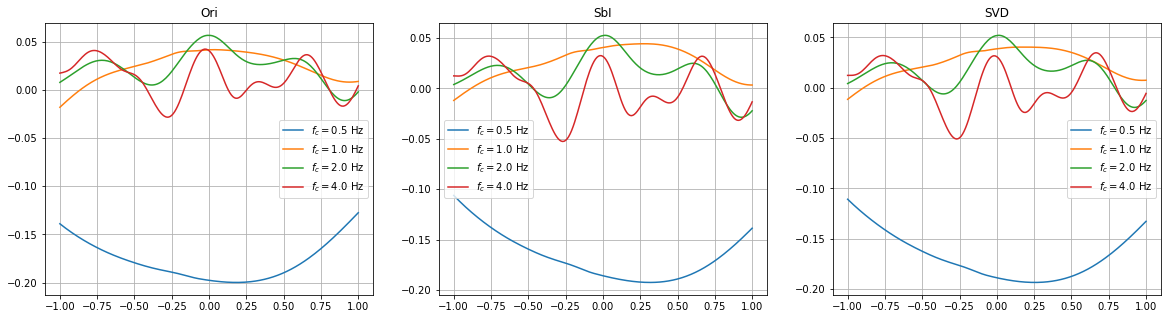

In [24]:
fig, ax = plt.subplots(1,3)
j = -1
for STKtype in ['Ori', 'SbI', 'SVD']:
    j += 1
    ax[j].set_title(STKtype)
    for i in range(len(LPOU_list)):  
        ax[j].plot(timeaxis,XcorrS[STKtype][i], label = r'$f_c=$'+str(Fc_list[i])+' Hz')
    ax[j].grid('on')
    ax[j].legend( )
fig.set_size_inches(20,5)

### MI

In [25]:
tv_list = [ndimage.gaussian_filter1d(LPOU, order=1, sigma=1)/dt  for LPOU in LPOU_list]
#assign states
state_num = 6
xstate_list = [EqualState(LPOU, state_num)[0] for LPOU in LPOU_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

rstates = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    rstates[STKtype] = [SG(r, dt, 0, 2, 10) for r in cellResponses[STKtype]]

In [26]:
MIs = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    MIs[STKtype] = [0]*len(LPOU_list)
    for i in range(len(LPOU_list)):
        timeshift, MIs[STKtype][i] = MIfunc(rstates[STKtype][i], xstate_list[i], dt, window)

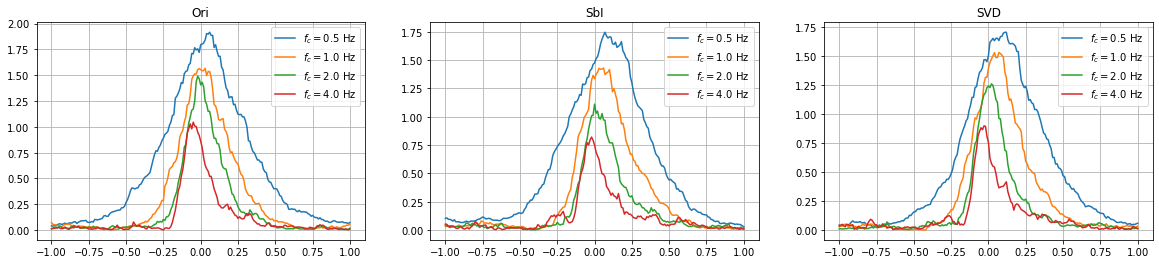

In [27]:
fig, ax = plt.subplots(1,3)
j = 0
for STKtype in ['Ori', 'SbI', 'SVD']:
    for i in range(len(LPOU_list)):
        ax[j].plot(timeaxis, MIs[STKtype][i], label = r'$f_c=$'+str(Fc_list[i])+' Hz')
    ax[j].set_title(STKtype)
    ax[j].legend()
    ax[j].grid('on')
    j += 1
fig.set_size_inches(20,4)

In [28]:
Is = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    Is[STKtype] = [0]*len(LPOU_list)
    for i in range(len(LPOU_list)):
        timeshift, Is[STKtype][i] = PIfunc(rstates[STKtype][i], xstate_list[i], tvstate_list[i], dt, window)

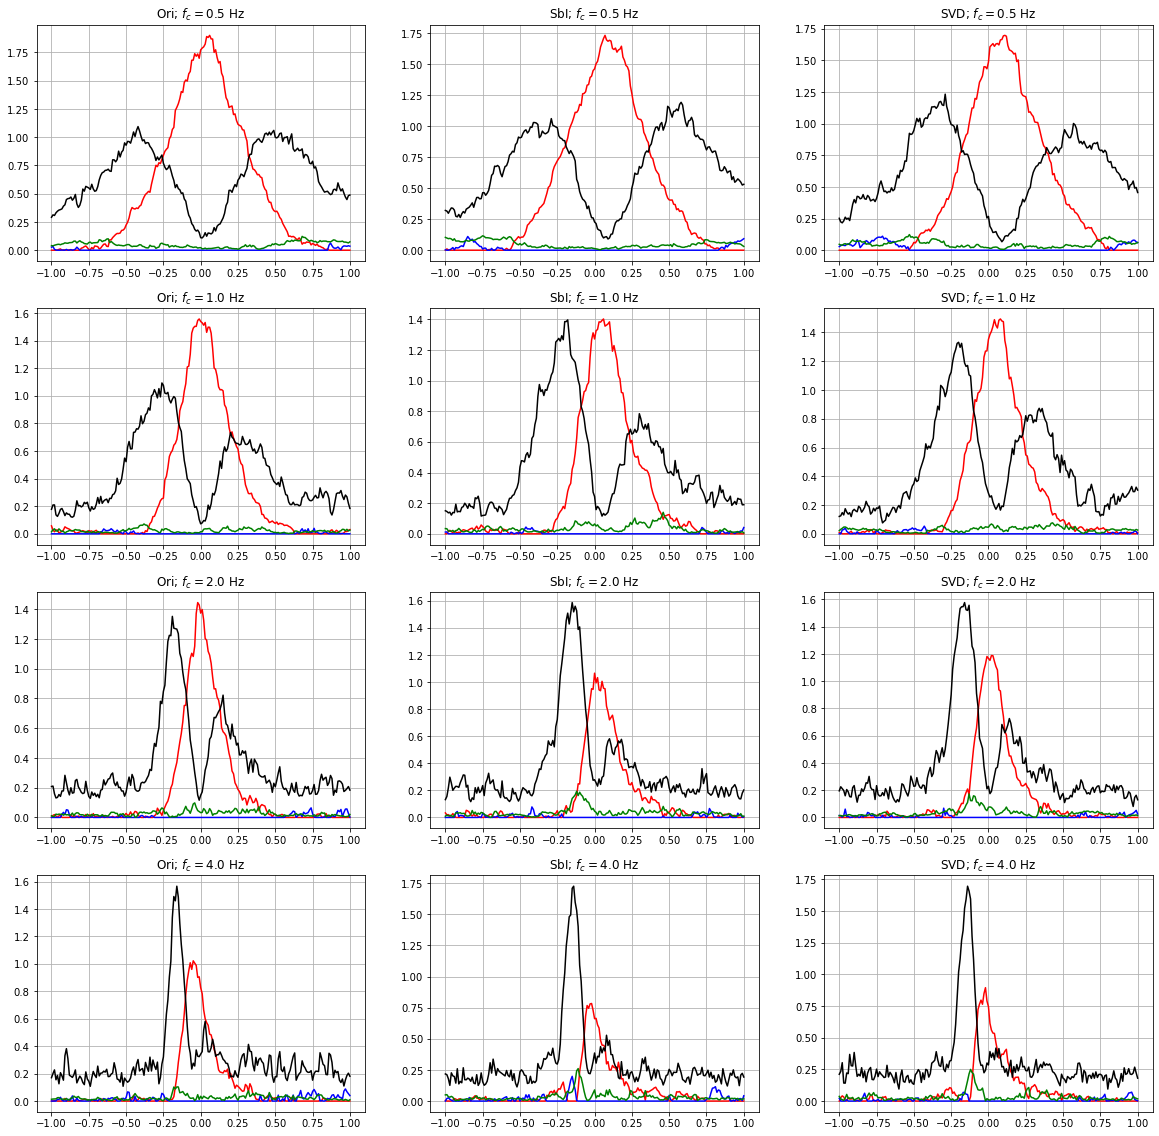

In [29]:
fig, ax = plt.subplots(len(LPOU_list),3)
j = 0
for STKtype in ['Ori', 'SbI', 'SVD']:
    for i in range(len(LPOU_list)):  
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','UIx')], 'r')
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','UIv')], 'b')
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','Syn')], 'k')
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','Red')], 'g')
        ax[i][j].set_title(STKtype+r'; $f_c=$'+str(Fc_list[i])+' Hz')
        # ax[i][j].legend()
        ax[i][j].grid('on')
    j += 1
fig.set_size_inches(20,5*len(LPOU_list))

## gain control

In [30]:
#Gain control function
def gain_func(v):
    v[v < 0] = 0
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)
    decay = decay[:,np.newaxis]

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i,:] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1,:]*dt ,axis=0))
        opi = gain[i,:]*r[i,:]
        output[i,:] = opi
    output[output<0] = 0
    return  output, gain

In [31]:
barIntensity = 6.5
B = 150  #To tune altitude of gain control (D=1/T)
tau = 0.3

Gains = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    Responses[STKtype+'+GC'] = [0]*len(LPOU_list)
    Gains[STKtype] = [0]*len(LPOU_list)
    for i in range(len(LPOU_list)):  
        Responses[STKtype+'+GC'][i], Gains[STKtype][i] = AddGainControl(barIntensity*Responses[STKtype][i], B, tau)

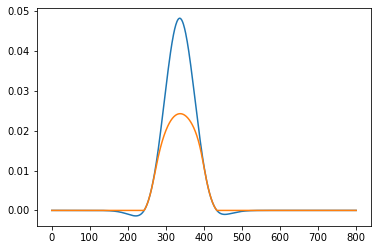

In [32]:
i = 0
plt.plot(Responses['Ori'][i][-1,:]*barIntensity)
plt.plot(Responses['Ori+GC'][i][-1,:])

In [33]:
for STKtype in ['Ori+GC', 'SbI+GC', 'SVD+GC']:
    cellResponses[STKtype] = [r[:, CellIndex] for r in Responses[STKtype]]

In [34]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

for STKtype in ['Ori+GC', 'SbI+GC', 'SVD+GC']:
    XcorrS[STKtype] = []
    for i in range(len(LPOU_list)):
        x = np.array(LPOU_list[i])
        x = (x-np.mean(x))/np.std(x)

        r = cellResponses[STKtype][i]
        r = NL(r, np.mean(r))
        Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
        Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
        XcorrS[STKtype].append( Xcorr.copy() )

### STA

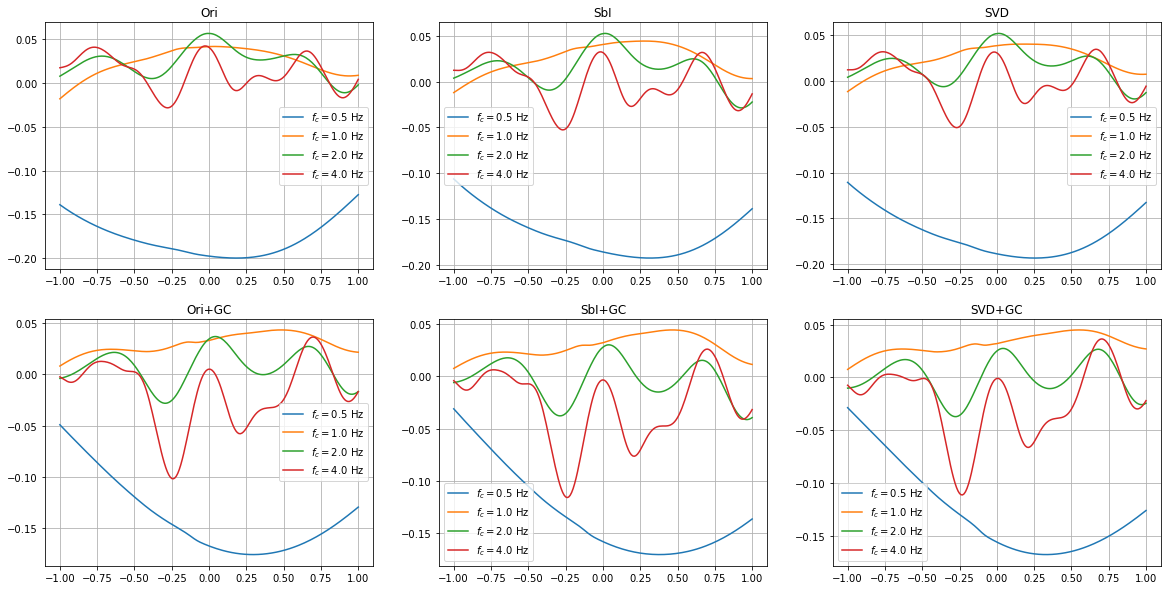

In [35]:
fig, ax = plt.subplots(2,3)
j = 0
for STKtype in XcorrS.keys():
    for i in range(len(LPOU_list)):  
        ax.flatten()[j].plot(timeaxis,XcorrS[STKtype][i], label = r'$f_c=$'+str(Fc_list[i])+' Hz')
    ax.flatten()[j].legend()
    ax.flatten()[j].set_title(STKtype)
    ax.flatten()[j].grid('on')
    j += 1
fig.set_size_inches(20,10)

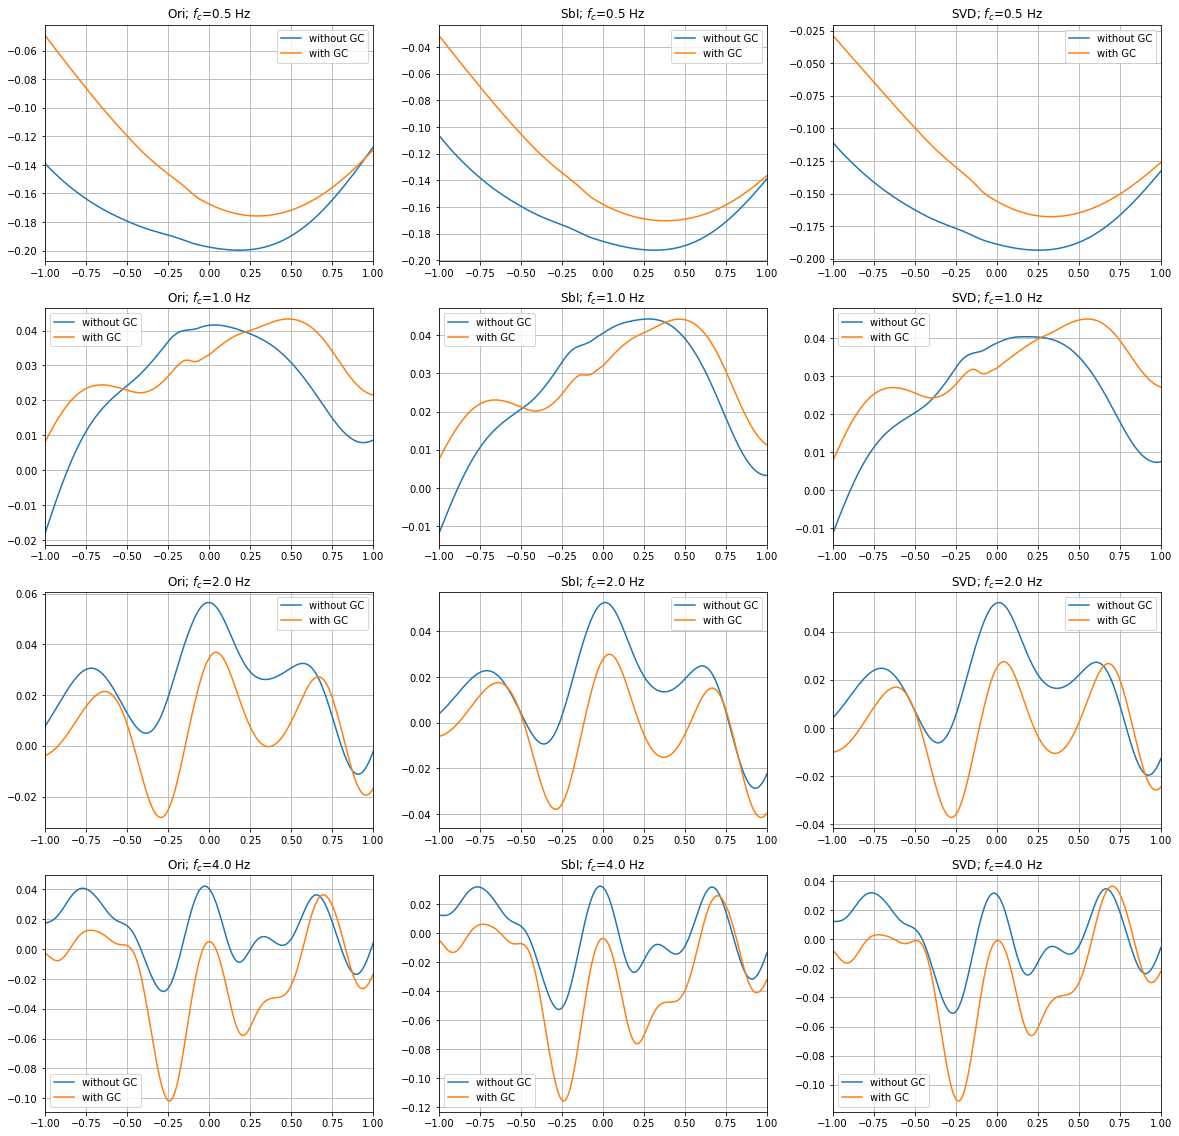

In [36]:
fig, ax = plt.subplots(len(LPOU_list),3)
j = 0
for STKtype in ['Ori', 'SbI', 'SVD']:
    for i in range(len(LPOU_list)):  
        ax[i][j].plot(timeaxis,XcorrS[STKtype][i], label = 'without GC')
        ax[i][j].plot(timeaxis,XcorrS[STKtype+'+GC'][i], label = 'with GC')
        ax[i][j].set_xlim(window)
        ax[i][j].set_title(STKtype+r'; $f_c$='+str(Fc_list[i])+' Hz')
        ax[i][j].legend()
        ax[i][j].grid('on')
    j += 1
fig.set_size_inches(20,5*len(LPOU_list))

### MI

In [37]:
for STKtype in ['Ori+GC', 'SbI+GC', 'SVD+GC']:
    rstates[STKtype] = [SG(r, dt, 0, 2, 10) for r in cellResponses[STKtype]]

In [38]:
for STKtype in ['Ori+GC', 'SbI+GC', 'SVD+GC']:
    MIs[STKtype] = [0]*len(LPOU_list)
    for i in range(len(LPOU_list)):
        timeshift, MIs[STKtype][i] = MIfunc(rstates[STKtype][i], xstate_list[i], dt, window)

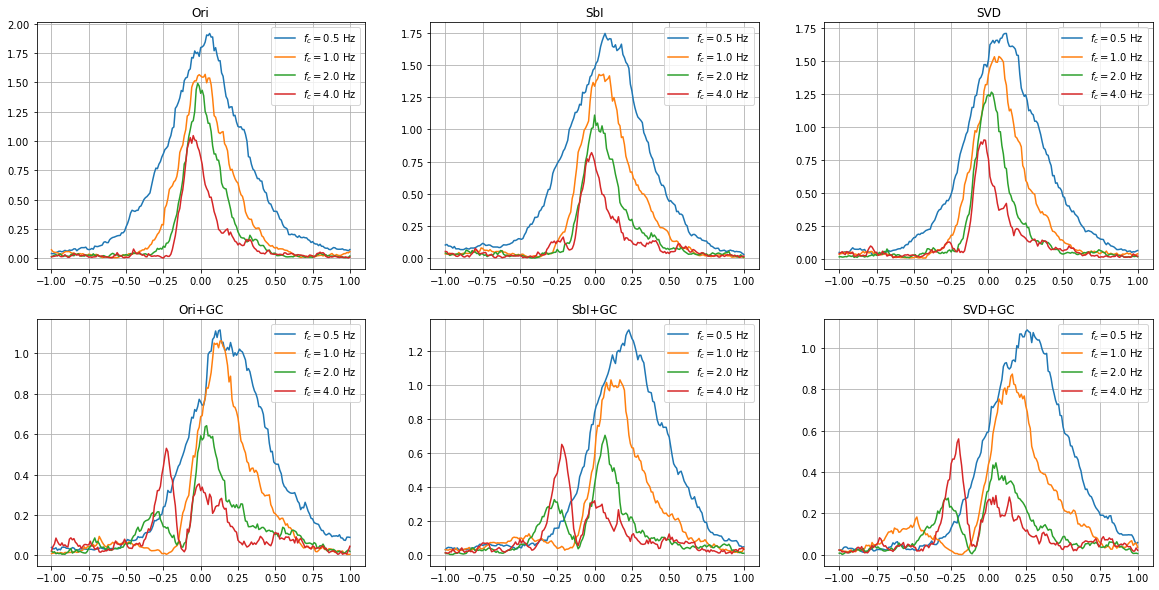

In [39]:
fig, ax = plt.subplots(2,3)
j = 0
for STKtype in XcorrS.keys():
    for i in range(len(LPOU_list)):
        ax.flatten()[j].plot(timeaxis, MIs[STKtype][i], label = r'$f_c=$'+str(Fc_list[i])+' Hz')
    ax.flatten()[j].set_title(STKtype)
    ax.flatten()[j].legend()
    ax.flatten()[j].grid('on')
    j+=1
fig.set_size_inches(20,10)


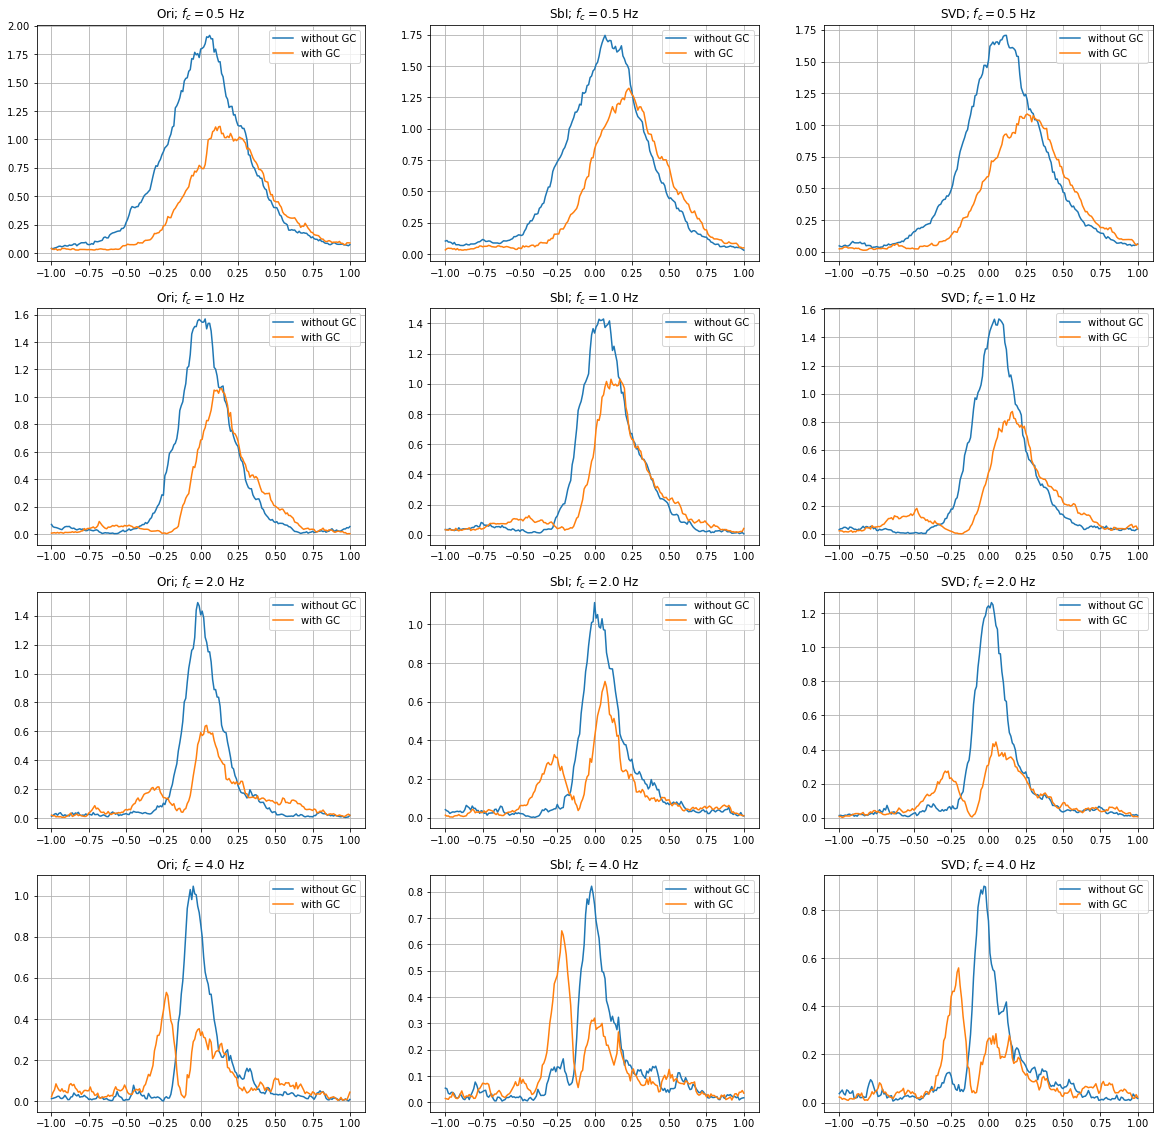

In [40]:
fig, ax = plt.subplots(len(LPOU_list),3)
j = 0
for STKtype in ['Ori', 'SbI', 'SVD']:
    for i in range(len(LPOU_list)):  
        ax[i][j].plot(timeaxis,MIs[STKtype][i], label = 'without GC')
        ax[i][j].plot(timeaxis,MIs[STKtype+'+GC'][i], label = 'with GC')
        ax[i][j].set_title(STKtype+r'; $f_c=$'+str(Fc_list[i])+' Hz')
        ax[i][j].legend()
        ax[i][j].grid('on')
    j += 1
fig.set_size_inches(20,5*len(LPOU_list))

In [41]:
Is = {}
for STKtype in ['Ori+GC', 'SbI+GC', 'SVD+GC']:
    Is[STKtype] = [0]*len(LPOU_list)
    for i in range(len(LPOU_list)):
        timeshift, Is[STKtype][i] = PIfunc(rstates[STKtype][i], xstate_list[i], tvstate_list[i], dt, window)

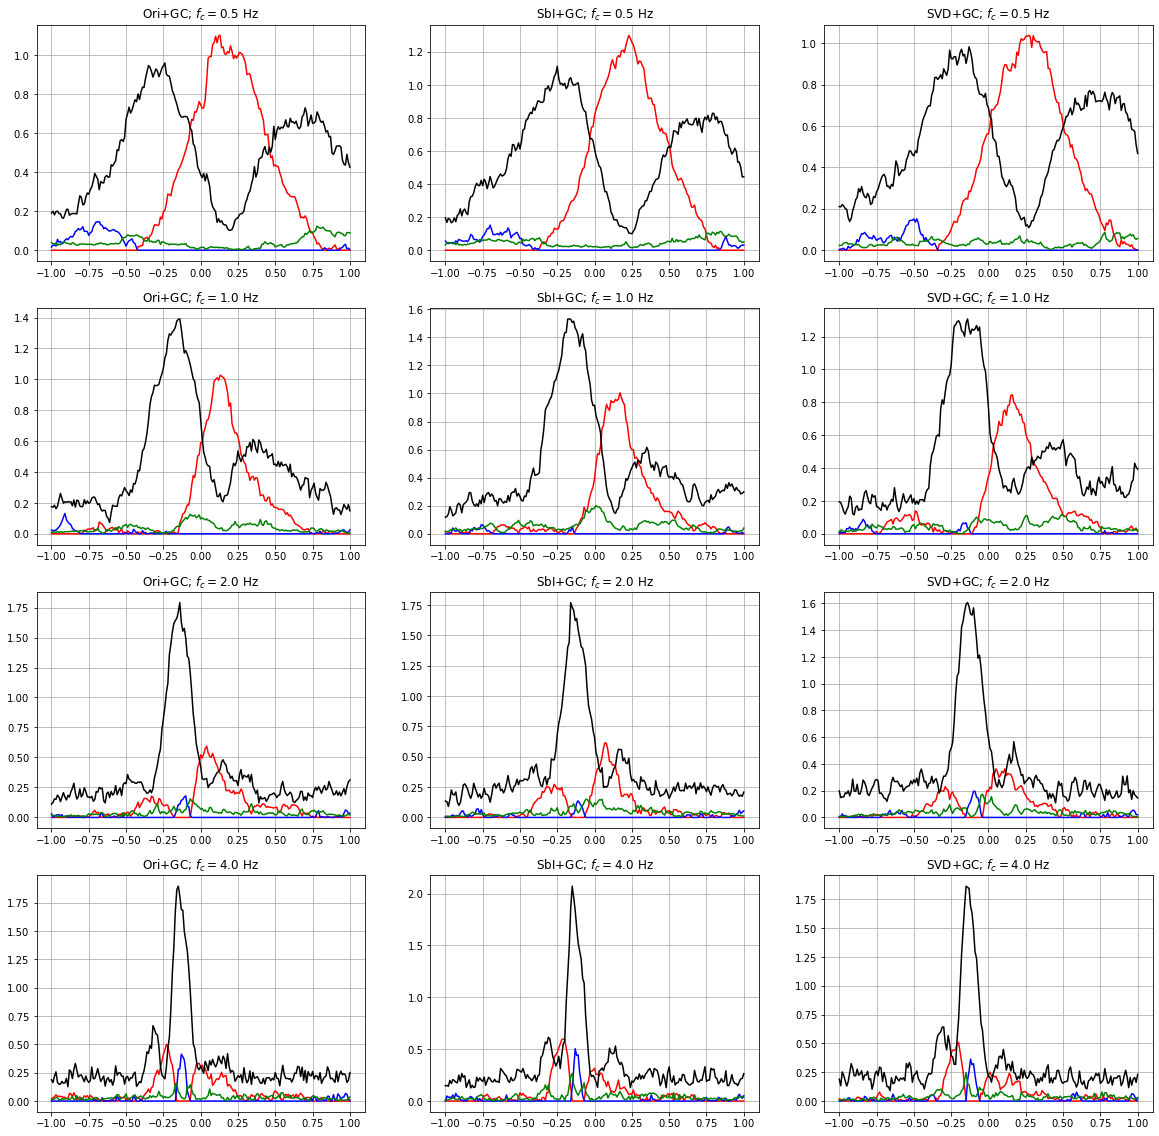

In [42]:
fig, ax = plt.subplots(len(LPOU_list),3)
j = 0
for STKtype in ['Ori+GC', 'SbI+GC', 'SVD+GC']:
    for i in range(len(LPOU_list)):  
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','UIx')], 'r')
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','UIv')], 'b')
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','Syn')], 'k')
        ax[i][j].plot(timeaxis,Is[STKtype][i][('Beer','Red')], 'g')
        ax[i][j].set_title(STKtype+r'; $f_c=$'+str(Fc_list[i])+' Hz')
        # ax[i][j].legend()
        ax[i][j].grid('on')
    j += 1
fig.set_size_inches(20,5*len(LPOU_list))